In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        fig.savefig("mnist_%d.png" % epoch)
        plt.close()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

/home/ajaykgp12/.local/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.843795, acc.: 53.12%] [G loss: 0.829769]


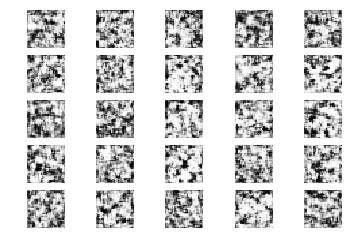

50 [D loss: 0.920070, acc.: 50.00%] [G loss: 1.460978]


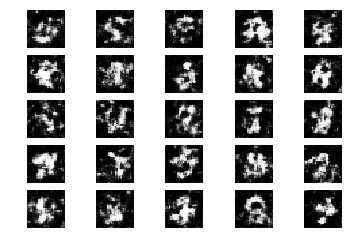

100 [D loss: 0.833442, acc.: 51.56%] [G loss: 1.272673]


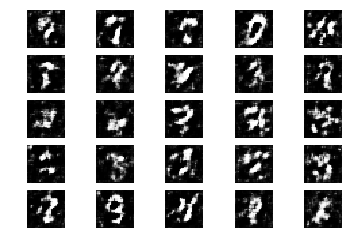

150 [D loss: 0.855724, acc.: 46.88%] [G loss: 1.200218]


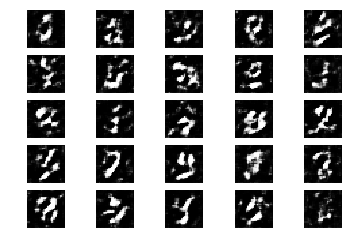

200 [D loss: 0.863927, acc.: 37.50%] [G loss: 0.979679]


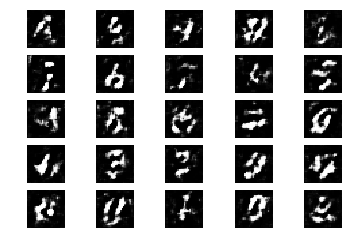

250 [D loss: 0.814528, acc.: 53.12%] [G loss: 1.083801]


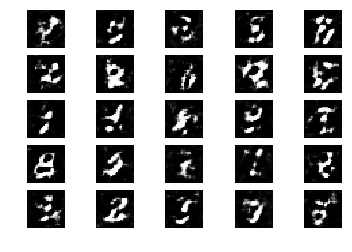

300 [D loss: 0.766398, acc.: 57.81%] [G loss: 1.184384]


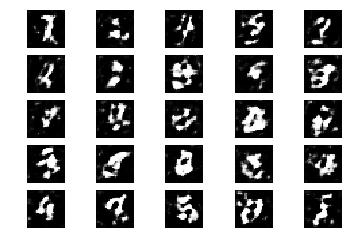

350 [D loss: 0.942542, acc.: 39.06%] [G loss: 0.865060]


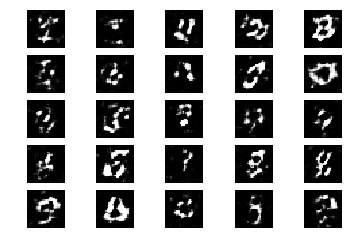

400 [D loss: 0.836158, acc.: 45.31%] [G loss: 1.113594]


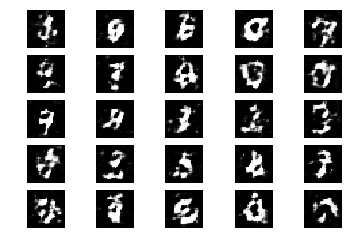

450 [D loss: 0.669553, acc.: 60.94%] [G loss: 1.029382]


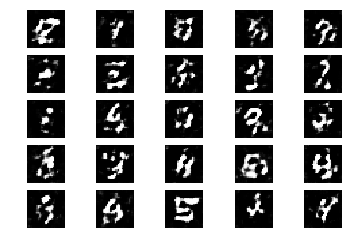

500 [D loss: 0.778773, acc.: 50.00%] [G loss: 0.917952]


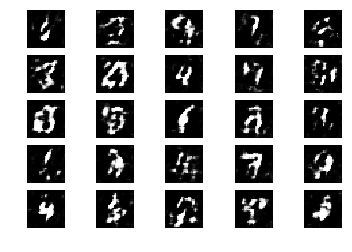

550 [D loss: 0.722677, acc.: 50.00%] [G loss: 0.980359]


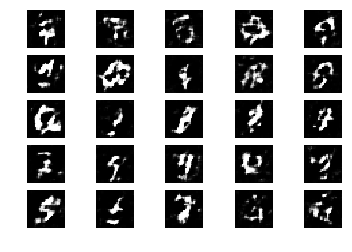

600 [D loss: 0.790688, acc.: 48.44%] [G loss: 1.016127]


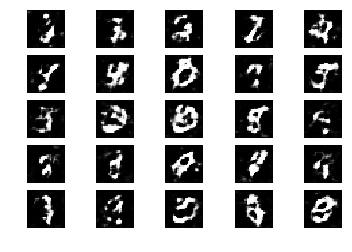

650 [D loss: 0.678612, acc.: 59.38%] [G loss: 1.014998]


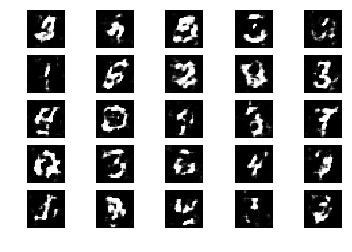

700 [D loss: 0.772760, acc.: 46.88%] [G loss: 0.977775]


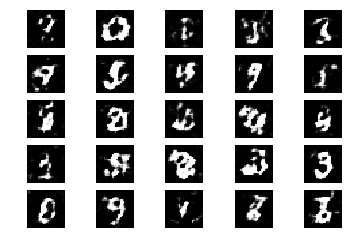

750 [D loss: 0.743874, acc.: 53.12%] [G loss: 0.916245]


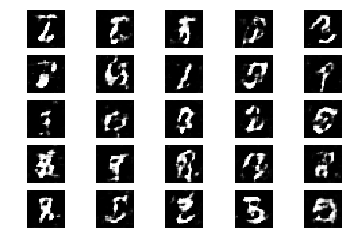

800 [D loss: 0.667246, acc.: 54.69%] [G loss: 1.034310]


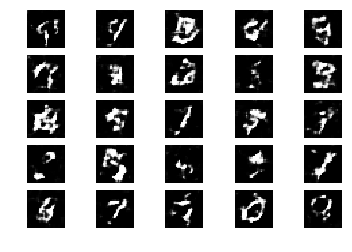

850 [D loss: 0.697848, acc.: 60.94%] [G loss: 0.843693]


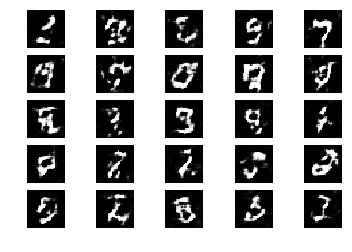

900 [D loss: 0.640280, acc.: 67.19%] [G loss: 0.920253]


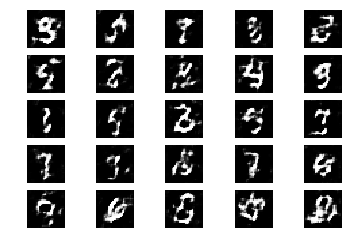

950 [D loss: 0.739472, acc.: 50.00%] [G loss: 1.128367]


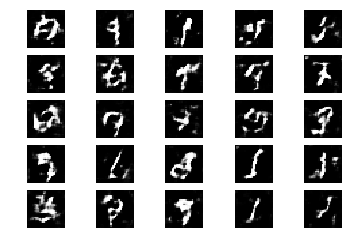

1000 [D loss: 0.666399, acc.: 62.50%] [G loss: 1.032399]


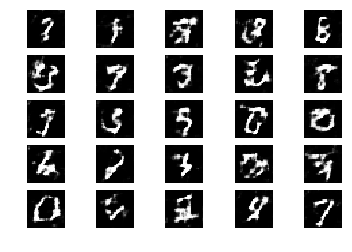

1050 [D loss: 0.600289, acc.: 71.88%] [G loss: 1.382767]


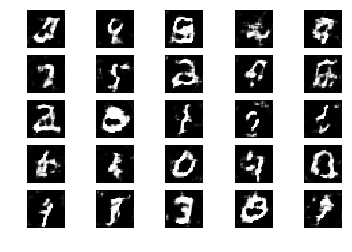

1100 [D loss: 0.707727, acc.: 60.94%] [G loss: 1.037261]


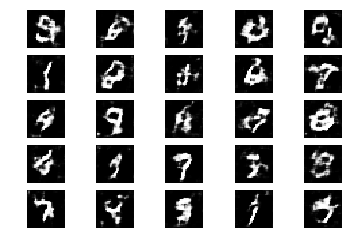

1150 [D loss: 0.765226, acc.: 51.56%] [G loss: 0.957857]


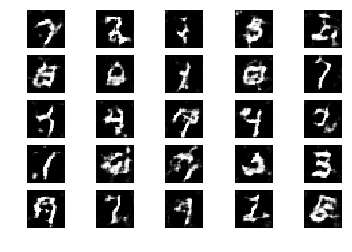

1200 [D loss: 0.662047, acc.: 68.75%] [G loss: 0.994485]


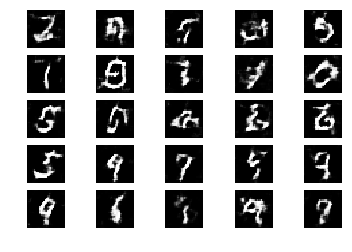

1250 [D loss: 0.719892, acc.: 45.31%] [G loss: 1.031656]


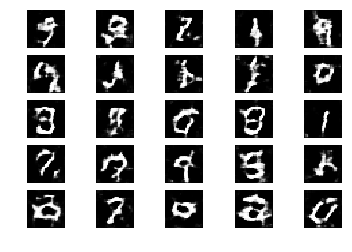

1300 [D loss: 0.714115, acc.: 57.81%] [G loss: 0.977488]


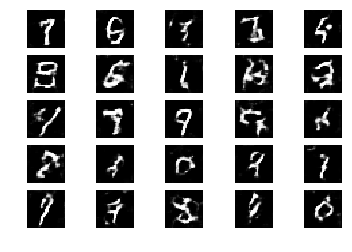

1350 [D loss: 0.675690, acc.: 56.25%] [G loss: 1.131476]


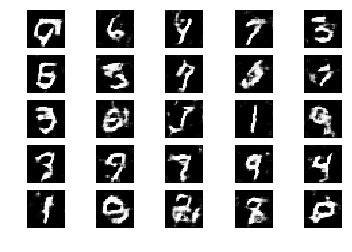

1400 [D loss: 0.699658, acc.: 57.81%] [G loss: 1.134068]


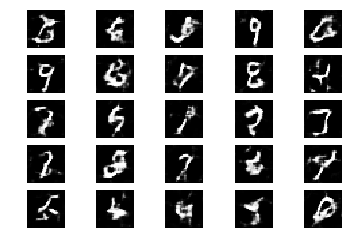

1450 [D loss: 0.653738, acc.: 56.25%] [G loss: 0.989238]


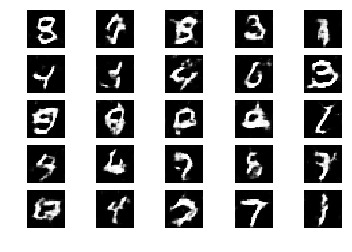

1500 [D loss: 0.716158, acc.: 57.81%] [G loss: 0.938249]


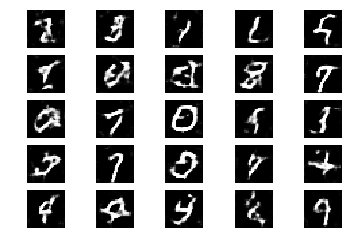

1550 [D loss: 0.616501, acc.: 71.88%] [G loss: 0.924198]


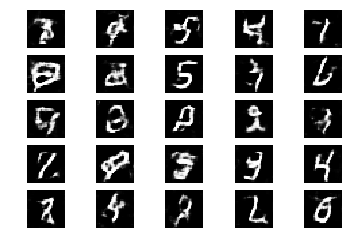

1600 [D loss: 0.679817, acc.: 53.12%] [G loss: 1.129800]


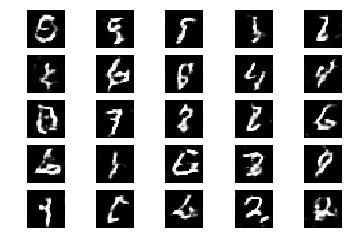

1650 [D loss: 0.643358, acc.: 62.50%] [G loss: 1.036396]


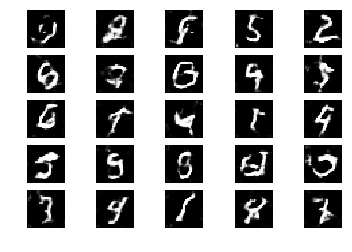

1700 [D loss: 0.595454, acc.: 68.75%] [G loss: 1.105361]


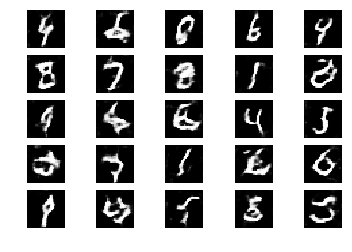

1750 [D loss: 0.682770, acc.: 51.56%] [G loss: 1.014970]


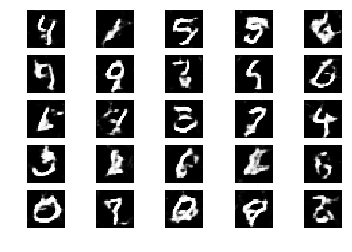

1800 [D loss: 0.558873, acc.: 75.00%] [G loss: 0.985006]


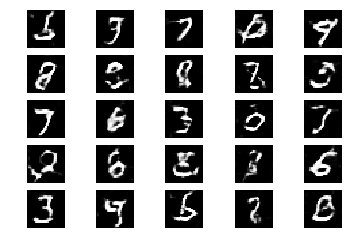

1850 [D loss: 0.611462, acc.: 71.88%] [G loss: 1.094298]


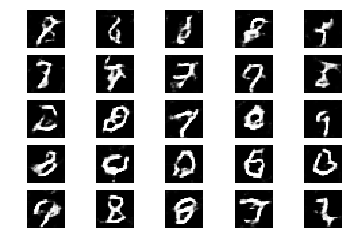

1900 [D loss: 0.617070, acc.: 70.31%] [G loss: 1.037773]


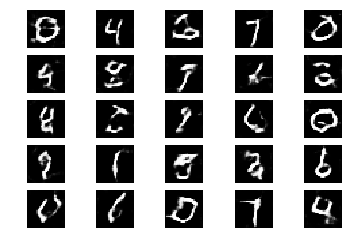

1950 [D loss: 0.662361, acc.: 60.94%] [G loss: 1.003187]


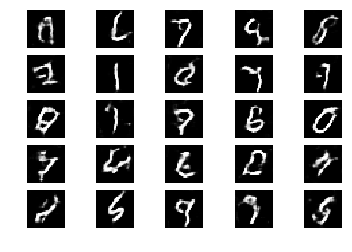

2000 [D loss: 0.678120, acc.: 60.94%] [G loss: 1.164106]


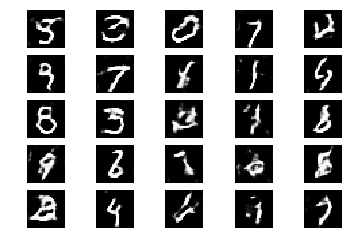

2050 [D loss: 0.620362, acc.: 60.94%] [G loss: 1.081023]


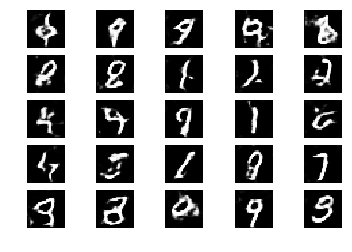

2100 [D loss: 0.711155, acc.: 53.12%] [G loss: 0.778773]


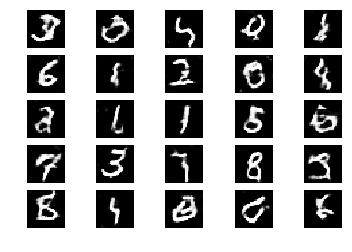

2150 [D loss: 0.592960, acc.: 67.19%] [G loss: 1.206770]


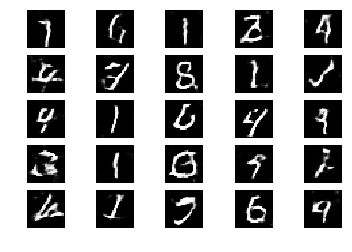

2200 [D loss: 0.581360, acc.: 68.75%] [G loss: 1.109282]


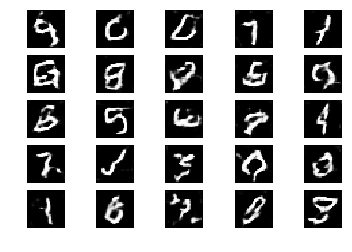

2250 [D loss: 0.763404, acc.: 46.88%] [G loss: 0.964800]


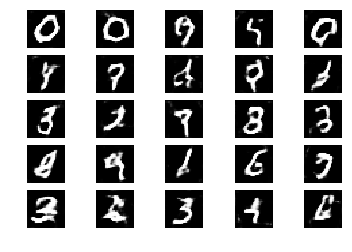

2300 [D loss: 0.801606, acc.: 54.69%] [G loss: 0.984405]


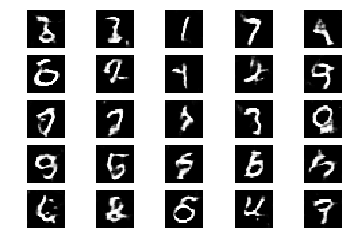

2350 [D loss: 0.705649, acc.: 54.69%] [G loss: 0.915194]


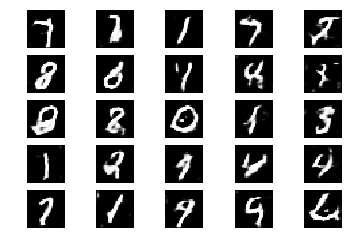

2400 [D loss: 0.586584, acc.: 73.44%] [G loss: 0.959483]


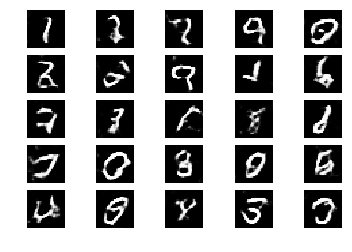

2450 [D loss: 0.670747, acc.: 57.81%] [G loss: 1.044364]


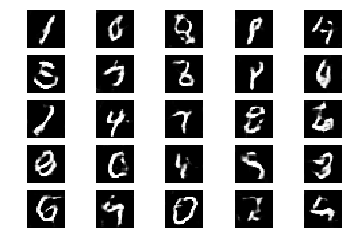

2500 [D loss: 0.718331, acc.: 54.69%] [G loss: 1.104549]


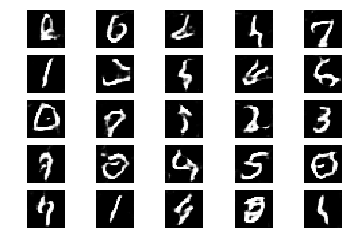

2550 [D loss: 0.644862, acc.: 64.06%] [G loss: 0.992136]


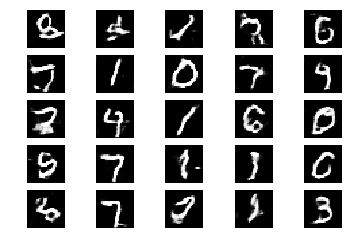

2600 [D loss: 0.688940, acc.: 57.81%] [G loss: 0.904331]


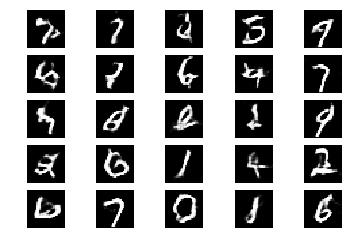

2650 [D loss: 0.691629, acc.: 60.94%] [G loss: 0.973472]


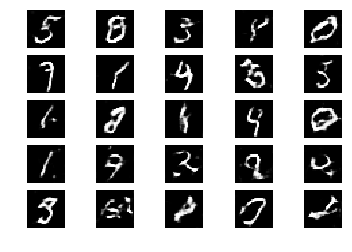

2700 [D loss: 0.641674, acc.: 57.81%] [G loss: 0.997690]


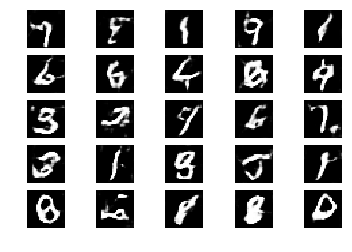

2750 [D loss: 0.739507, acc.: 51.56%] [G loss: 0.941940]


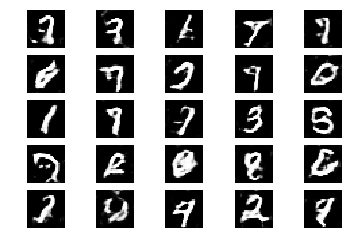

2800 [D loss: 0.625735, acc.: 67.19%] [G loss: 1.140316]


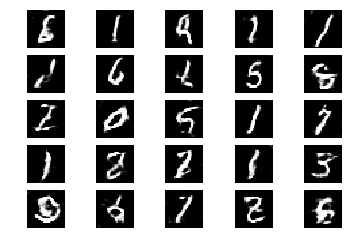

2850 [D loss: 0.622728, acc.: 65.62%] [G loss: 1.099953]


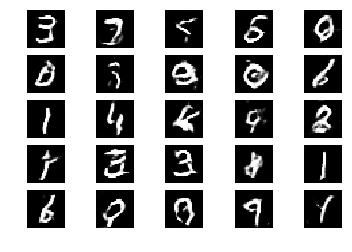

2900 [D loss: 0.711064, acc.: 53.12%] [G loss: 0.930131]


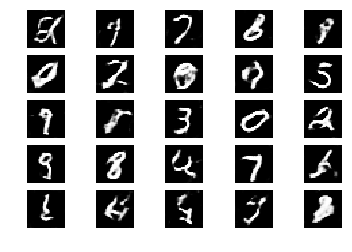

2950 [D loss: 0.677192, acc.: 59.38%] [G loss: 1.197362]


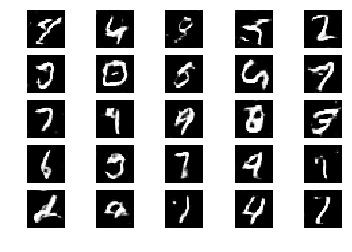

3000 [D loss: 0.606640, acc.: 68.75%] [G loss: 1.060352]


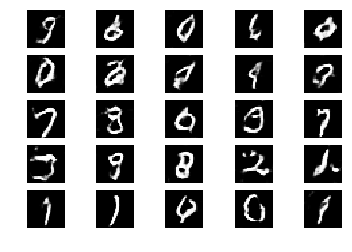

3050 [D loss: 0.627086, acc.: 67.19%] [G loss: 1.103302]


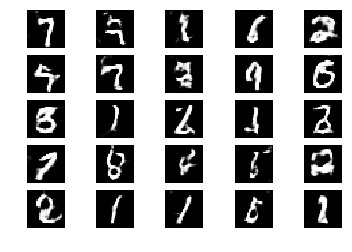

3100 [D loss: 0.721300, acc.: 50.00%] [G loss: 0.930924]


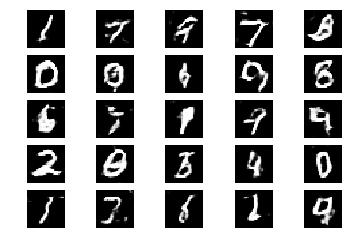

3150 [D loss: 0.662039, acc.: 67.19%] [G loss: 1.286500]


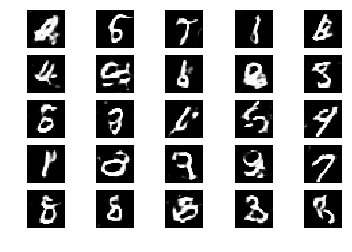

3200 [D loss: 0.629223, acc.: 70.31%] [G loss: 0.871503]


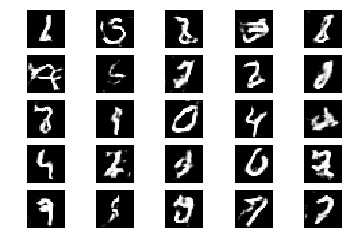

3250 [D loss: 0.683803, acc.: 57.81%] [G loss: 0.924324]


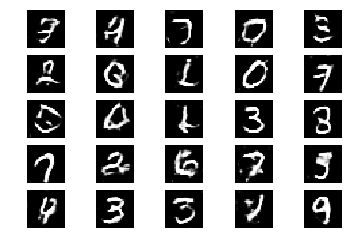

3300 [D loss: 0.516638, acc.: 73.44%] [G loss: 0.873685]


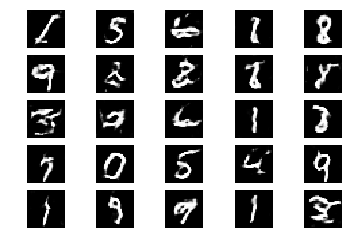

3350 [D loss: 0.715103, acc.: 57.81%] [G loss: 1.087342]


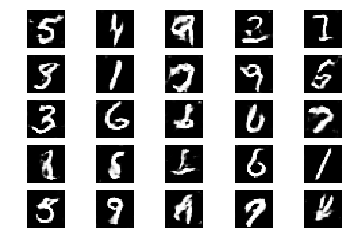

3400 [D loss: 0.651439, acc.: 64.06%] [G loss: 0.960791]


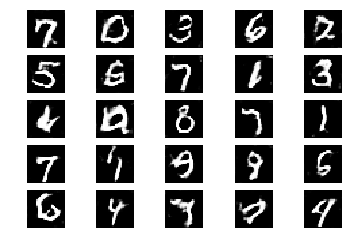

3450 [D loss: 0.729283, acc.: 54.69%] [G loss: 0.762771]


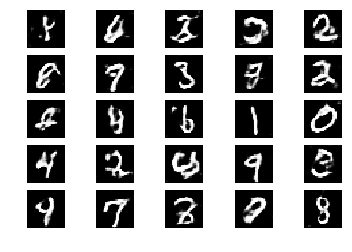

3500 [D loss: 0.768006, acc.: 60.94%] [G loss: 1.005311]


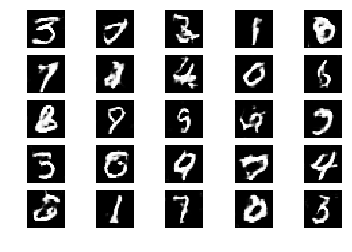

3550 [D loss: 0.743037, acc.: 51.56%] [G loss: 0.984801]


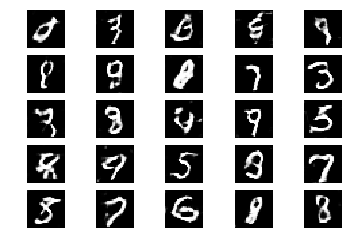

3600 [D loss: 0.607124, acc.: 73.44%] [G loss: 0.959571]


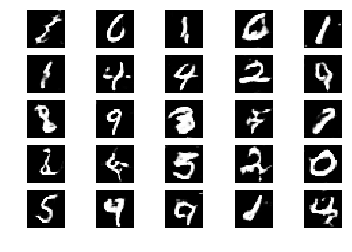

3650 [D loss: 0.721053, acc.: 53.12%] [G loss: 0.958722]


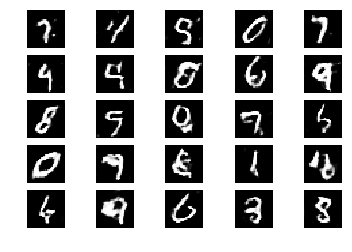

3700 [D loss: 0.813298, acc.: 43.75%] [G loss: 0.876556]


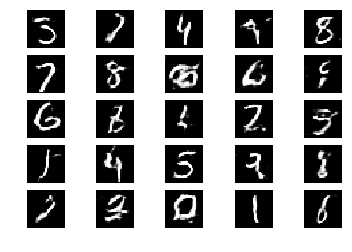

3750 [D loss: 0.546258, acc.: 71.88%] [G loss: 0.936631]


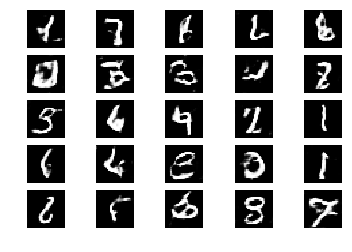

3800 [D loss: 0.597849, acc.: 67.19%] [G loss: 0.962586]


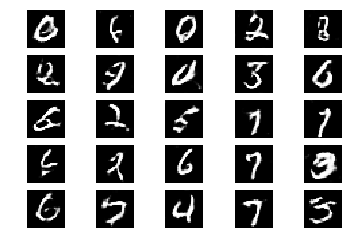

3850 [D loss: 0.512980, acc.: 82.81%] [G loss: 1.063329]


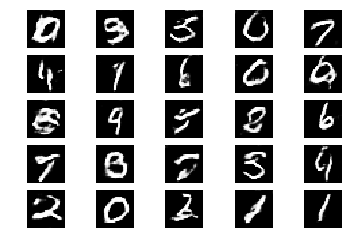

3900 [D loss: 0.718221, acc.: 51.56%] [G loss: 0.892128]


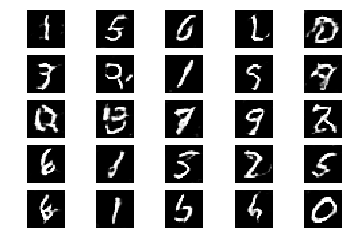

3950 [D loss: 0.703103, acc.: 62.50%] [G loss: 0.896556]


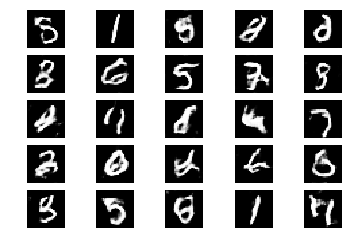

4000 [D loss: 0.757576, acc.: 45.31%] [G loss: 0.946249]


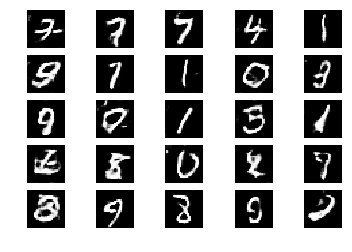

4050 [D loss: 0.682030, acc.: 59.38%] [G loss: 1.008946]


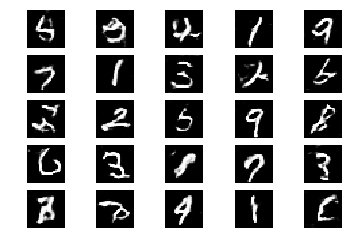

4100 [D loss: 0.611072, acc.: 65.62%] [G loss: 1.096961]


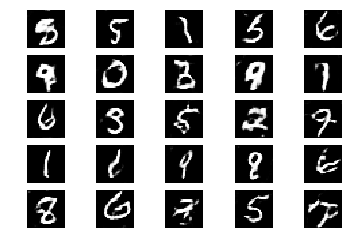

4150 [D loss: 0.723011, acc.: 64.06%] [G loss: 1.045067]


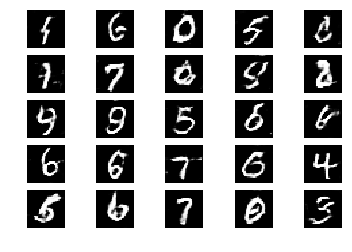

4200 [D loss: 0.699910, acc.: 54.69%] [G loss: 1.018683]


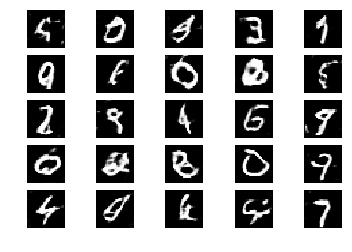

4250 [D loss: 0.647753, acc.: 59.38%] [G loss: 0.889975]


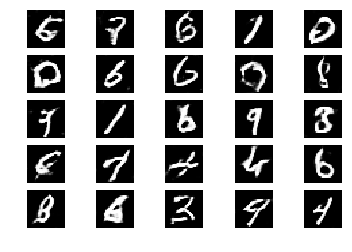

4300 [D loss: 0.599041, acc.: 76.56%] [G loss: 0.928904]


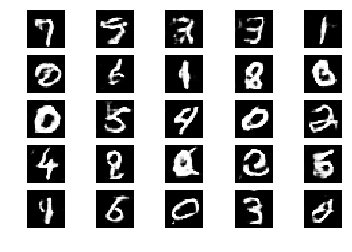

4350 [D loss: 0.624223, acc.: 64.06%] [G loss: 1.211716]


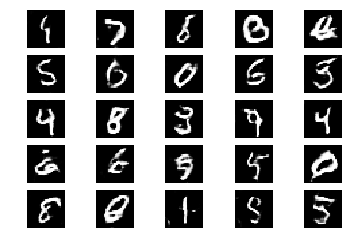

4400 [D loss: 0.560191, acc.: 76.56%] [G loss: 1.053174]


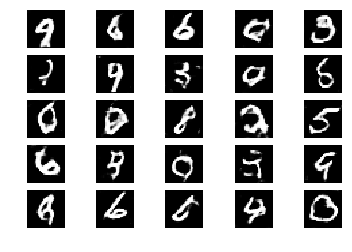

4450 [D loss: 0.638656, acc.: 60.94%] [G loss: 0.841228]


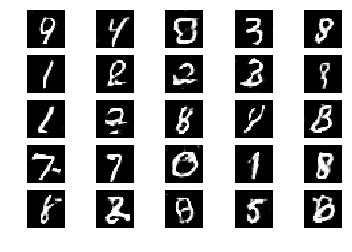

4500 [D loss: 0.746408, acc.: 48.44%] [G loss: 0.962673]


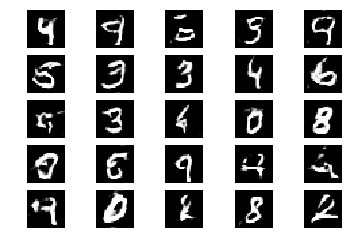

4550 [D loss: 0.574395, acc.: 70.31%] [G loss: 0.924472]


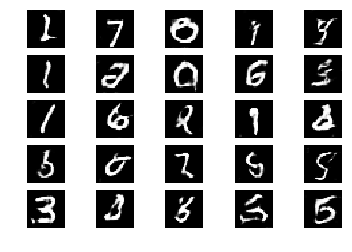

4600 [D loss: 0.696362, acc.: 53.12%] [G loss: 0.990032]


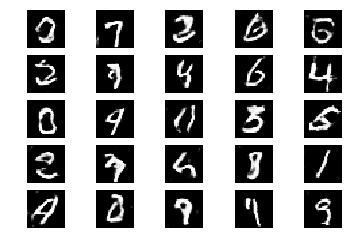

4650 [D loss: 0.609189, acc.: 64.06%] [G loss: 0.920938]


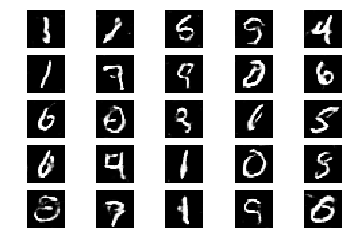

4700 [D loss: 0.707258, acc.: 48.44%] [G loss: 1.028860]


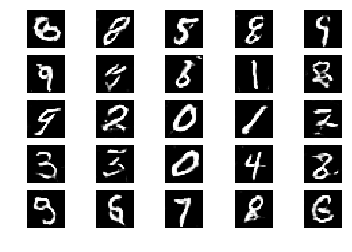

4750 [D loss: 0.631834, acc.: 75.00%] [G loss: 1.000021]


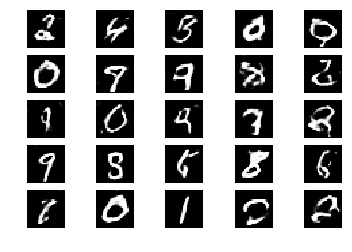

4800 [D loss: 0.633957, acc.: 65.62%] [G loss: 1.029499]


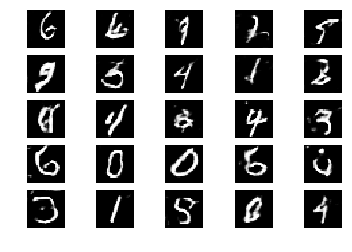

4850 [D loss: 0.671650, acc.: 59.38%] [G loss: 1.108736]


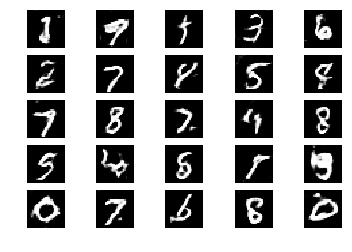

4900 [D loss: 0.679648, acc.: 60.94%] [G loss: 0.920755]


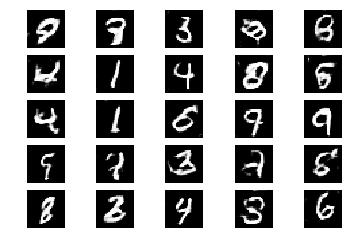

4950 [D loss: 0.602162, acc.: 73.44%] [G loss: 0.927752]


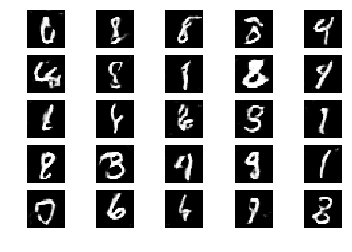

5000 [D loss: 0.644828, acc.: 56.25%] [G loss: 1.187287]


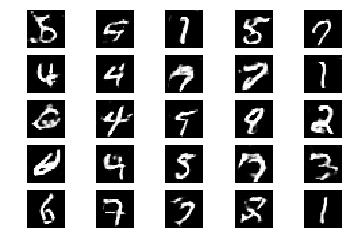

5050 [D loss: 0.701680, acc.: 53.12%] [G loss: 0.968009]


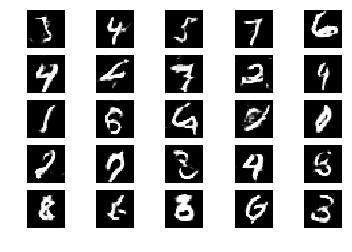

5100 [D loss: 0.601694, acc.: 71.88%] [G loss: 1.195875]


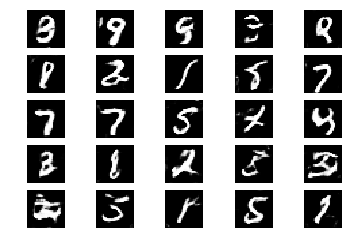

5150 [D loss: 0.653385, acc.: 60.94%] [G loss: 1.123032]


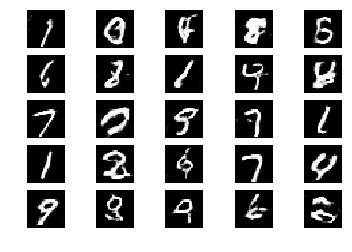

5200 [D loss: 0.645776, acc.: 67.19%] [G loss: 1.079706]


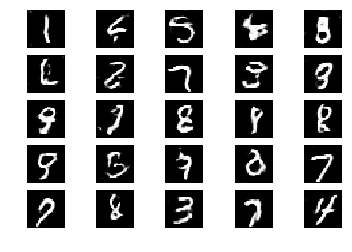

5250 [D loss: 0.829500, acc.: 42.19%] [G loss: 0.963779]


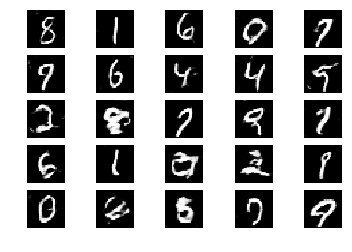

5300 [D loss: 0.768377, acc.: 53.12%] [G loss: 0.884408]


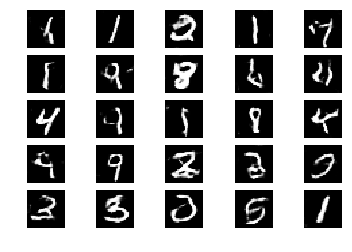

5350 [D loss: 0.531586, acc.: 73.44%] [G loss: 1.011074]


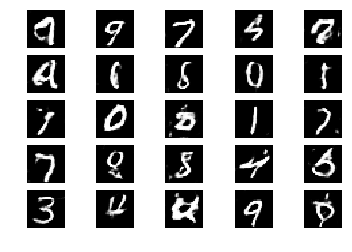

5400 [D loss: 0.616356, acc.: 67.19%] [G loss: 0.957764]


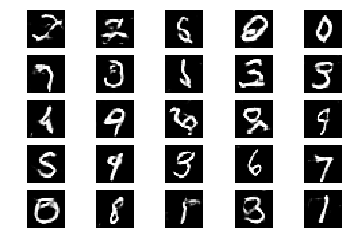

5450 [D loss: 0.753647, acc.: 53.12%] [G loss: 1.329388]


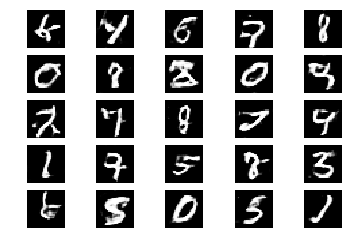

5500 [D loss: 0.677980, acc.: 51.56%] [G loss: 1.089191]


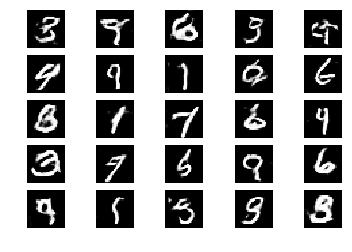

5550 [D loss: 0.635695, acc.: 64.06%] [G loss: 1.082906]


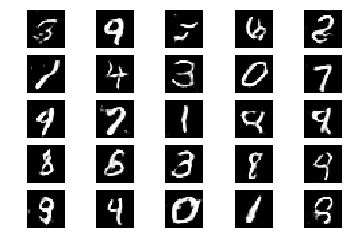

5600 [D loss: 0.754673, acc.: 43.75%] [G loss: 1.022028]


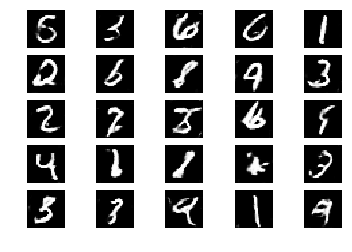

5650 [D loss: 0.619472, acc.: 70.31%] [G loss: 1.079158]


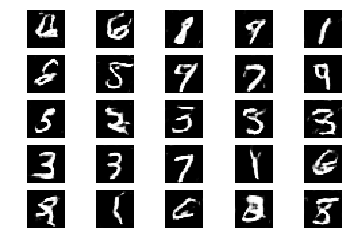

5700 [D loss: 0.675020, acc.: 57.81%] [G loss: 0.915045]


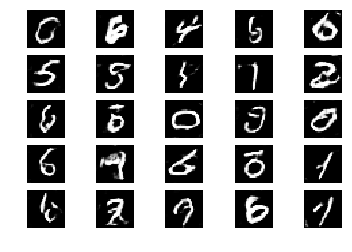

5750 [D loss: 0.545038, acc.: 75.00%] [G loss: 1.166220]


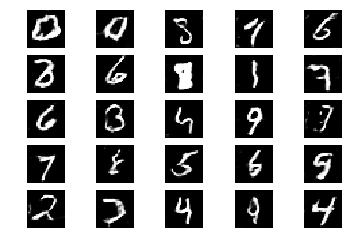

5800 [D loss: 0.631688, acc.: 68.75%] [G loss: 1.047088]


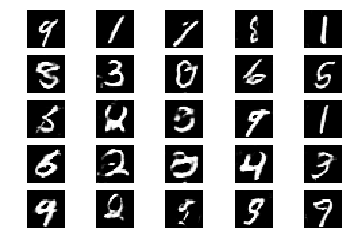

5850 [D loss: 0.693136, acc.: 59.38%] [G loss: 1.065250]


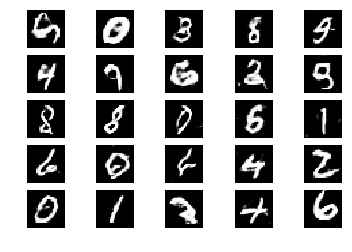

5900 [D loss: 0.657762, acc.: 65.62%] [G loss: 1.114029]


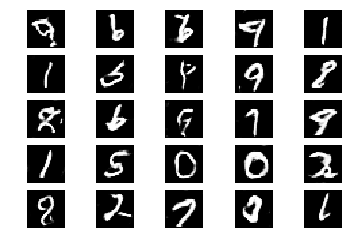

5950 [D loss: 0.590127, acc.: 71.88%] [G loss: 1.074154]


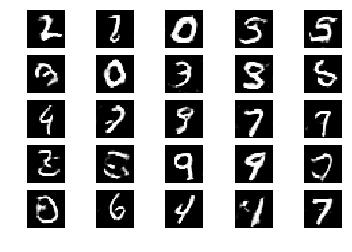

6000 [D loss: 0.646452, acc.: 57.81%] [G loss: 1.287807]


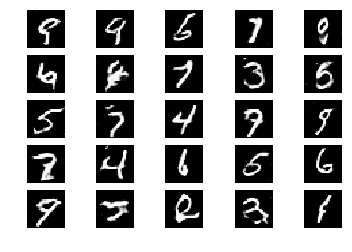

6050 [D loss: 0.736048, acc.: 53.12%] [G loss: 0.856009]


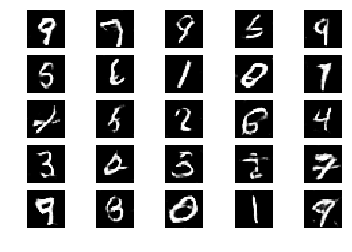

6100 [D loss: 0.601753, acc.: 68.75%] [G loss: 1.043334]


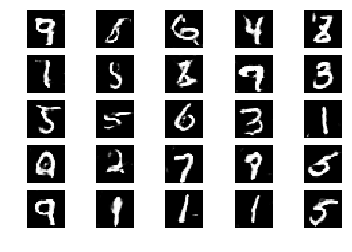

6150 [D loss: 0.679509, acc.: 53.12%] [G loss: 1.087643]


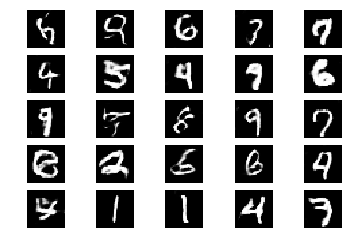

6200 [D loss: 0.732083, acc.: 51.56%] [G loss: 1.247238]


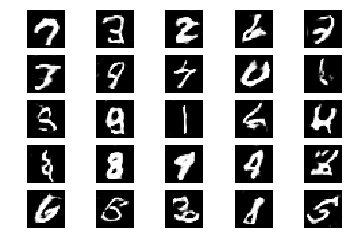

6250 [D loss: 0.647013, acc.: 59.38%] [G loss: 0.885698]


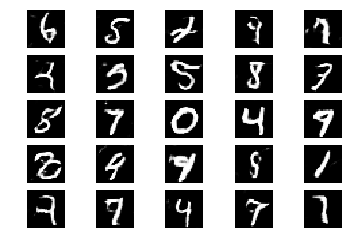

6300 [D loss: 0.703544, acc.: 56.25%] [G loss: 1.081017]


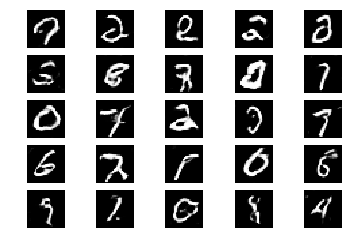

6350 [D loss: 0.658446, acc.: 54.69%] [G loss: 1.035788]


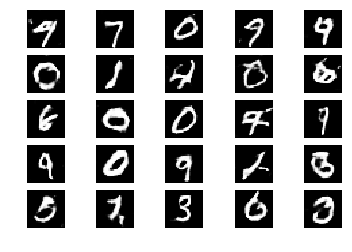

6400 [D loss: 0.584384, acc.: 64.06%] [G loss: 0.954553]


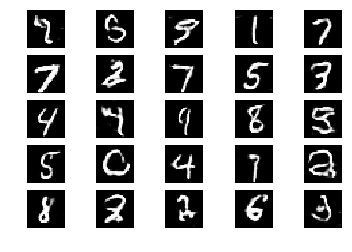

6450 [D loss: 0.605502, acc.: 67.19%] [G loss: 0.877580]


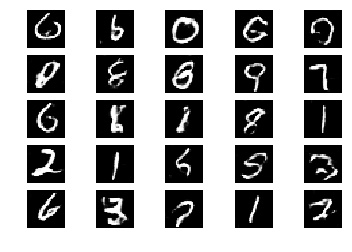

6500 [D loss: 0.521193, acc.: 84.38%] [G loss: 1.124688]


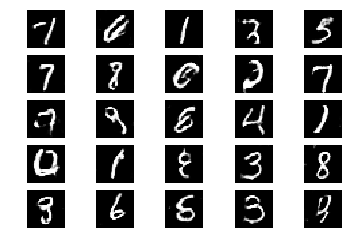

6550 [D loss: 0.659895, acc.: 56.25%] [G loss: 0.889980]


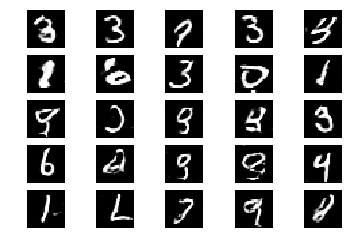

6600 [D loss: 0.586486, acc.: 70.31%] [G loss: 0.994138]


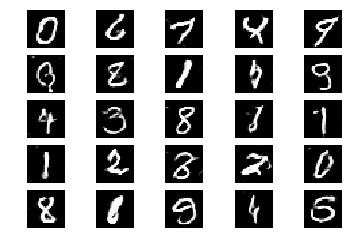

6650 [D loss: 0.538537, acc.: 79.69%] [G loss: 1.203288]


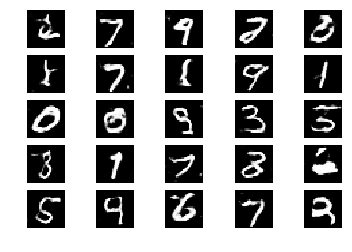

6700 [D loss: 0.717079, acc.: 53.12%] [G loss: 0.919912]


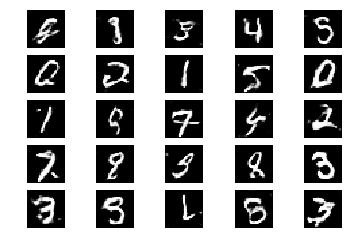

6750 [D loss: 0.597909, acc.: 64.06%] [G loss: 1.139519]


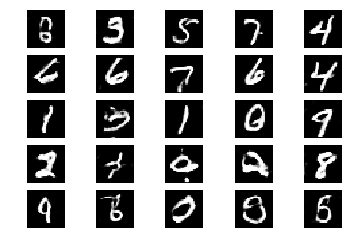

6800 [D loss: 0.570035, acc.: 71.88%] [G loss: 1.098073]


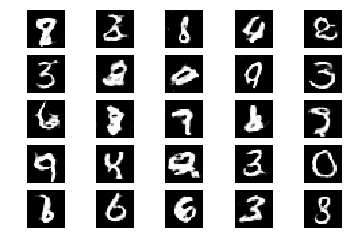

6850 [D loss: 0.683915, acc.: 54.69%] [G loss: 0.979420]


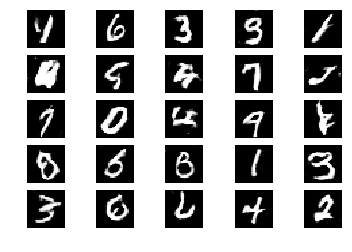

6900 [D loss: 0.735622, acc.: 51.56%] [G loss: 1.023327]


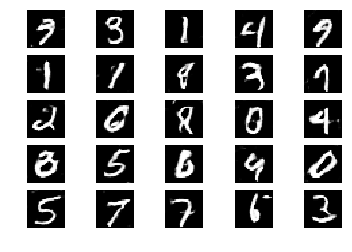

6950 [D loss: 0.616128, acc.: 65.62%] [G loss: 1.031612]


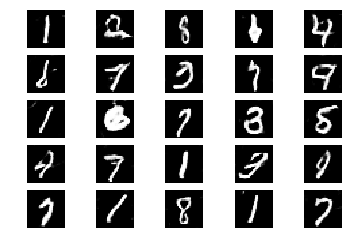

7000 [D loss: 0.665166, acc.: 56.25%] [G loss: 0.769288]


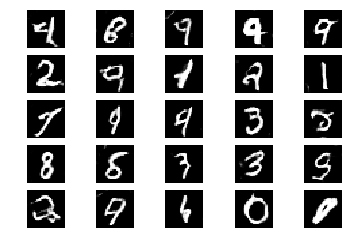

7050 [D loss: 0.544122, acc.: 76.56%] [G loss: 1.223433]


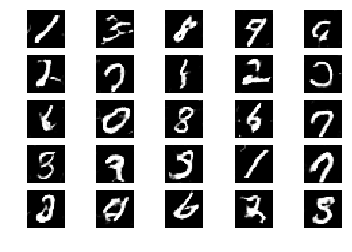

7100 [D loss: 0.627694, acc.: 56.25%] [G loss: 1.037533]


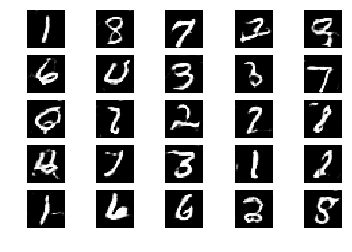

7150 [D loss: 0.604313, acc.: 64.06%] [G loss: 1.107098]


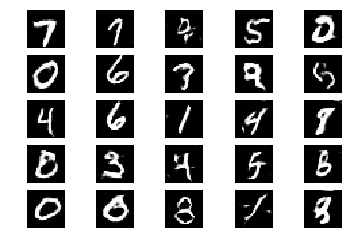

7200 [D loss: 0.575145, acc.: 70.31%] [G loss: 1.129145]


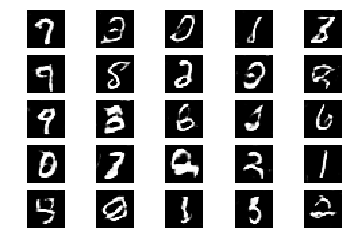

7250 [D loss: 0.648149, acc.: 65.62%] [G loss: 1.028130]


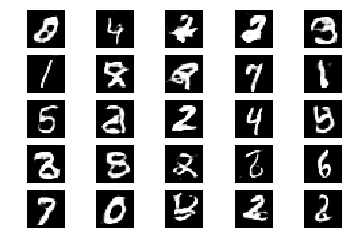

7300 [D loss: 0.629195, acc.: 68.75%] [G loss: 1.264857]


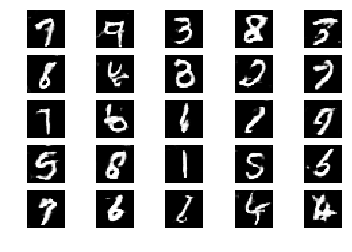

7350 [D loss: 0.656860, acc.: 60.94%] [G loss: 1.083323]


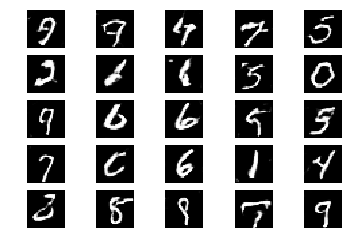

7400 [D loss: 0.679560, acc.: 60.94%] [G loss: 1.232177]


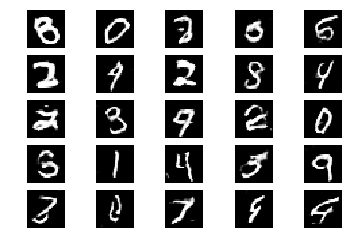

7450 [D loss: 0.636615, acc.: 65.62%] [G loss: 1.080905]


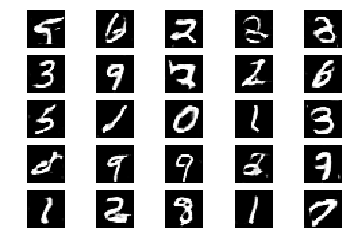

7500 [D loss: 0.591985, acc.: 68.75%] [G loss: 0.914906]


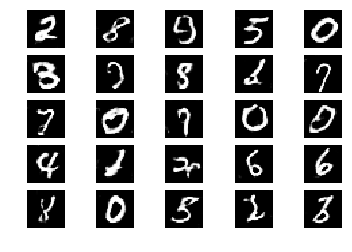

7550 [D loss: 0.641593, acc.: 57.81%] [G loss: 0.705100]


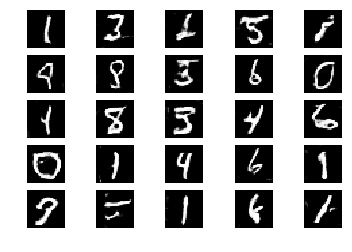

7600 [D loss: 0.651747, acc.: 57.81%] [G loss: 1.136333]


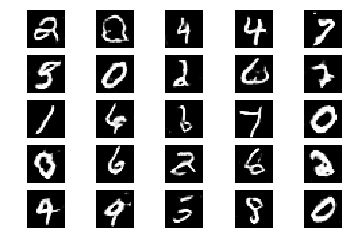

7650 [D loss: 0.631247, acc.: 62.50%] [G loss: 1.136304]


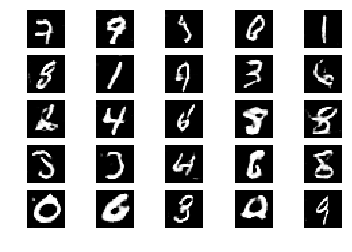

7700 [D loss: 0.533186, acc.: 75.00%] [G loss: 0.958183]


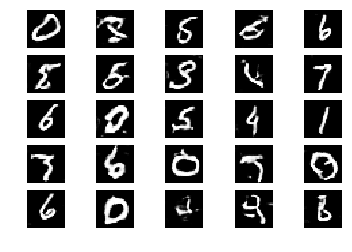

7750 [D loss: 0.563801, acc.: 67.19%] [G loss: 1.089235]


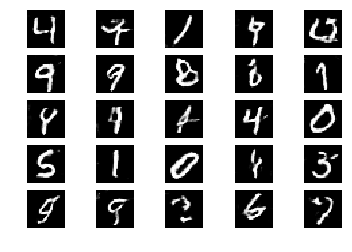

7800 [D loss: 0.703553, acc.: 60.94%] [G loss: 1.080185]


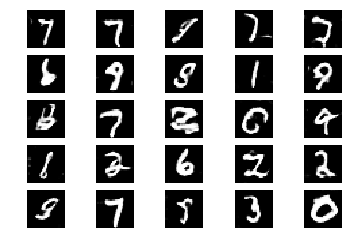

7850 [D loss: 0.621309, acc.: 59.38%] [G loss: 1.160736]


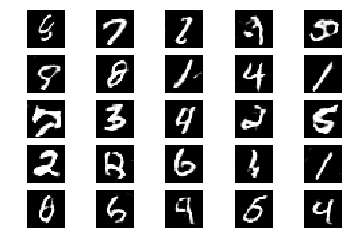

7900 [D loss: 0.597883, acc.: 68.75%] [G loss: 1.117091]


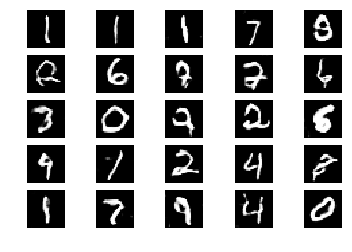

7950 [D loss: 0.755674, acc.: 48.44%] [G loss: 1.079510]


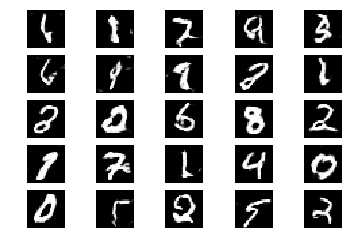

8000 [D loss: 0.636821, acc.: 67.19%] [G loss: 1.009131]


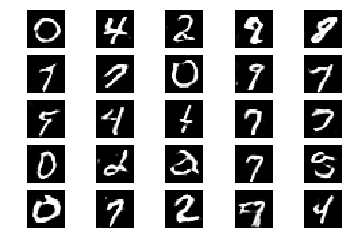

8050 [D loss: 0.619681, acc.: 68.75%] [G loss: 1.015607]


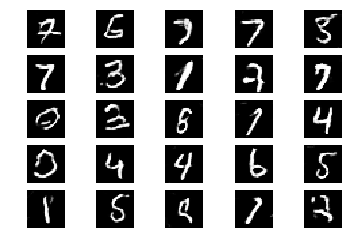

8100 [D loss: 0.616670, acc.: 60.94%] [G loss: 0.943373]


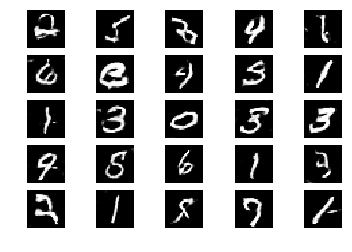

8150 [D loss: 0.625402, acc.: 64.06%] [G loss: 1.047176]


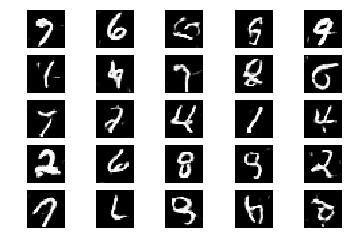

8200 [D loss: 0.673082, acc.: 65.62%] [G loss: 1.035118]


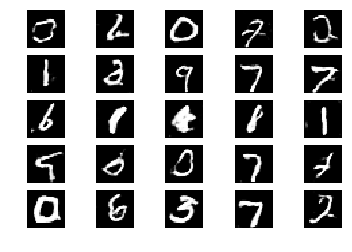

8250 [D loss: 0.673996, acc.: 57.81%] [G loss: 1.146798]


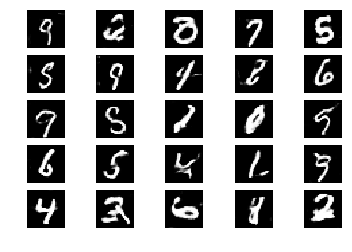

8300 [D loss: 0.671492, acc.: 62.50%] [G loss: 1.068409]


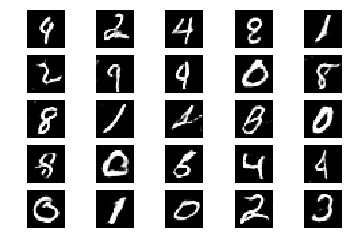

8350 [D loss: 0.658959, acc.: 56.25%] [G loss: 0.854796]


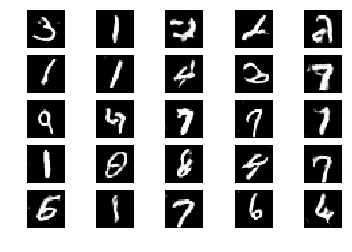

8400 [D loss: 0.535263, acc.: 81.25%] [G loss: 1.152634]


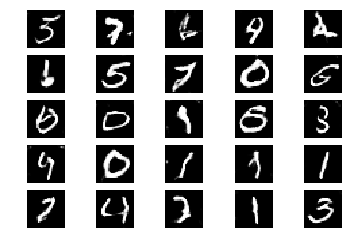

8450 [D loss: 0.850293, acc.: 45.31%] [G loss: 0.950910]


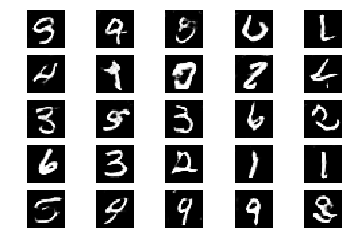

8500 [D loss: 0.544339, acc.: 73.44%] [G loss: 1.105901]


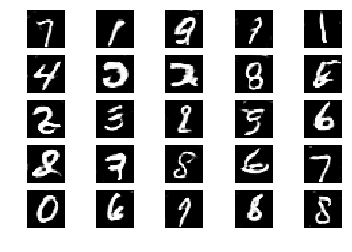

8550 [D loss: 0.518446, acc.: 76.56%] [G loss: 1.258533]


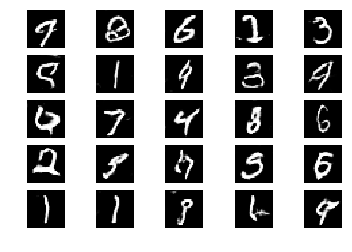

8600 [D loss: 0.554984, acc.: 68.75%] [G loss: 1.287620]


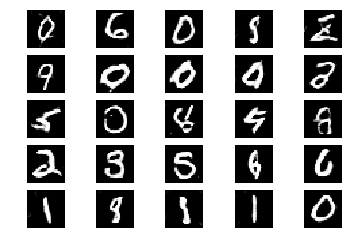

8650 [D loss: 0.560503, acc.: 73.44%] [G loss: 1.219717]


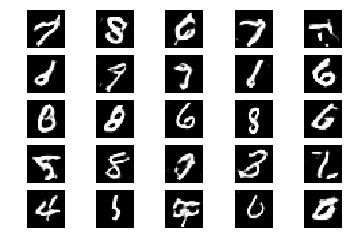

8700 [D loss: 0.711955, acc.: 59.38%] [G loss: 1.233591]


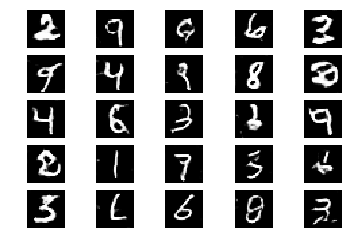

8750 [D loss: 0.694989, acc.: 56.25%] [G loss: 1.237867]


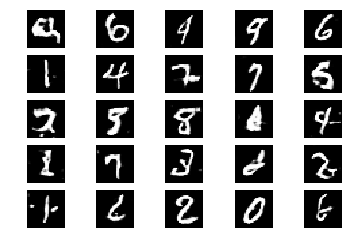

8800 [D loss: 0.549743, acc.: 71.88%] [G loss: 1.289149]


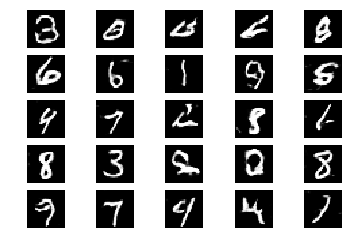

8850 [D loss: 0.598987, acc.: 67.19%] [G loss: 1.017537]


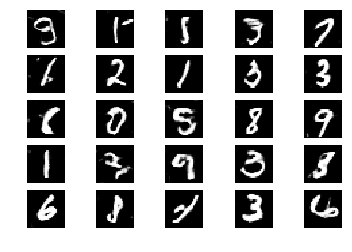

8900 [D loss: 0.671652, acc.: 54.69%] [G loss: 1.297181]


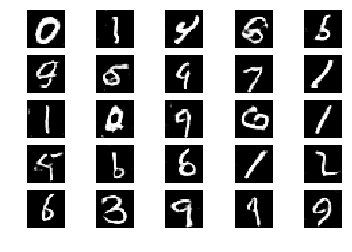

8950 [D loss: 0.509918, acc.: 78.12%] [G loss: 1.376841]


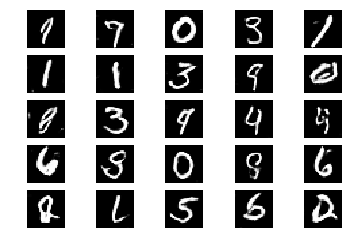

9000 [D loss: 0.698620, acc.: 57.81%] [G loss: 0.971785]


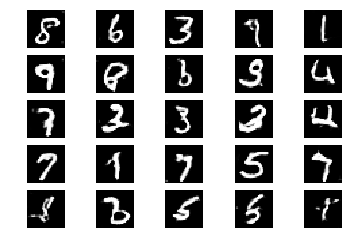

9050 [D loss: 0.663296, acc.: 62.50%] [G loss: 1.077755]


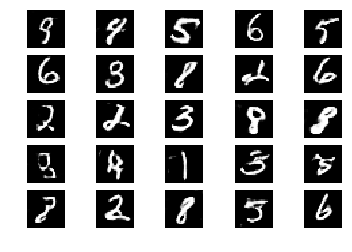

9100 [D loss: 0.790760, acc.: 53.12%] [G loss: 1.046664]


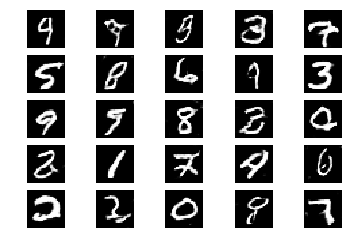

9150 [D loss: 0.633647, acc.: 67.19%] [G loss: 0.898272]


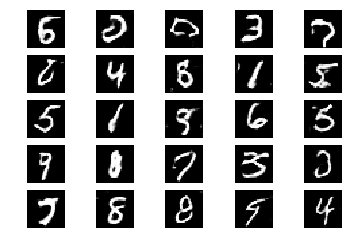

9200 [D loss: 0.566608, acc.: 71.88%] [G loss: 1.038864]


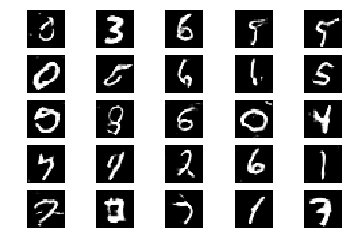

9250 [D loss: 0.749600, acc.: 45.31%] [G loss: 0.977009]


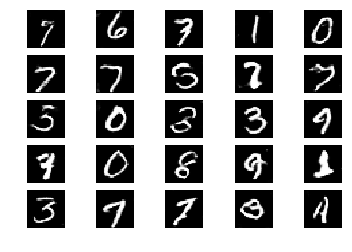

9300 [D loss: 0.537825, acc.: 76.56%] [G loss: 1.243522]


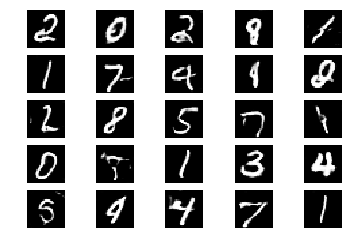

9350 [D loss: 0.549695, acc.: 76.56%] [G loss: 0.786046]


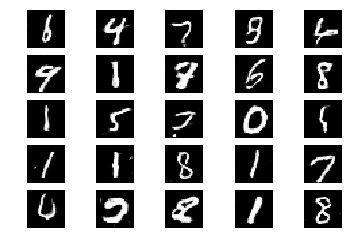

9400 [D loss: 0.729129, acc.: 51.56%] [G loss: 0.872781]


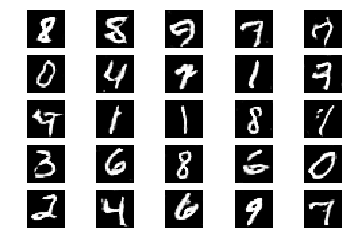

9450 [D loss: 0.524693, acc.: 76.56%] [G loss: 0.946171]


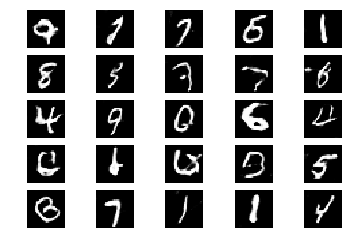

9500 [D loss: 0.572986, acc.: 75.00%] [G loss: 1.010767]


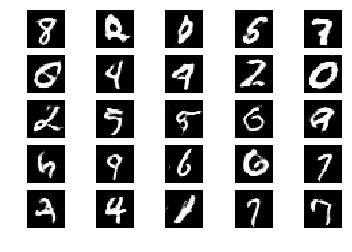

9550 [D loss: 0.742469, acc.: 51.56%] [G loss: 0.841711]


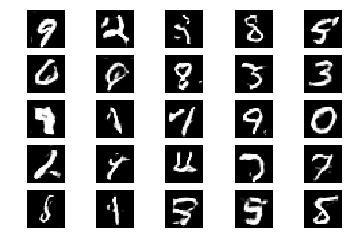

9600 [D loss: 0.631713, acc.: 60.94%] [G loss: 1.032571]


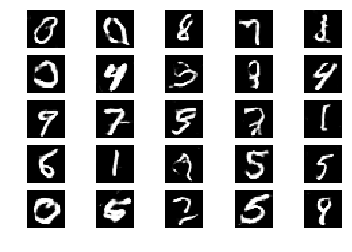

9650 [D loss: 0.662320, acc.: 59.38%] [G loss: 0.990741]


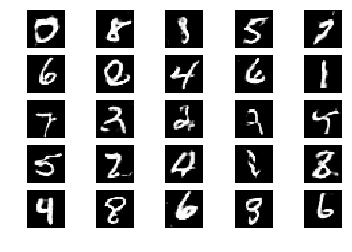

9700 [D loss: 0.568660, acc.: 70.31%] [G loss: 1.496831]


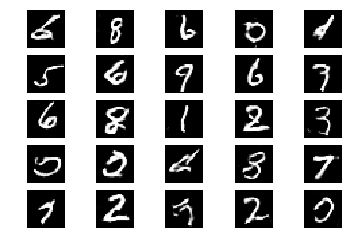

9750 [D loss: 0.539795, acc.: 75.00%] [G loss: 1.149389]


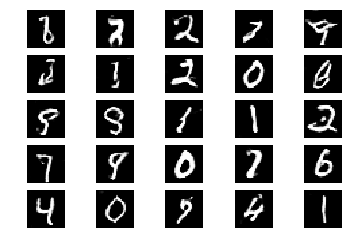

9800 [D loss: 0.598131, acc.: 70.31%] [G loss: 1.092488]


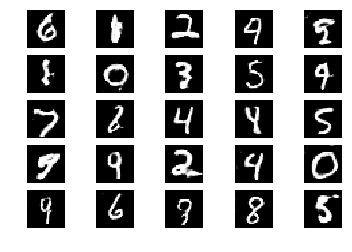

9850 [D loss: 0.769003, acc.: 46.88%] [G loss: 1.035351]


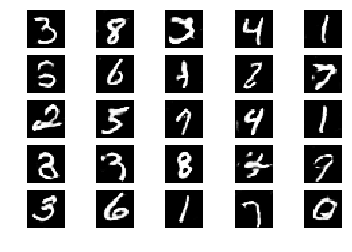

9900 [D loss: 0.639948, acc.: 57.81%] [G loss: 0.935840]


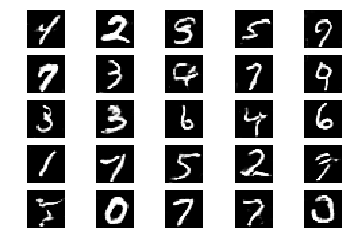

9950 [D loss: 0.674465, acc.: 59.38%] [G loss: 1.048717]


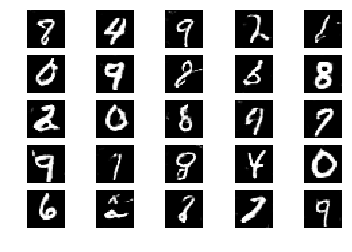

In [3]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=10000, batch_size=32, save_interval=50)